In [1]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Flatten,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    Rescaling,
)
from tensorflow.keras.optimizers import Adam
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageFile
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from pathlib import Path
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

2024-11-13 11:04:42.137161: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-13 11:04:42.147049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 11:04:42.158454: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 11:04:42.162015: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 11:04:42.170464: I tensorflow/core/platform/cpu_feature_guar

In [2]:
path = "/media/guimcc/Elements/data_2"

# Load sales data
train_df = pd.read_csv(Path(path + '/train.csv'), parse_dates=['release_date'])
test_df = pd.read_csv(Path(path + '/test.csv'), parse_dates=['release_date'])

In [3]:
ImageFile.LOAD_TRUNCATED_IMAGES = True


class ZeroShotDataset():
    def __init__(self, data_df, img_root, gtrends, cat_dict, col_dict, fab_dict, trend_len):
        self.data_df = data_df
        self.gtrends = gtrends
        self.cat_dict = cat_dict
        self.col_dict = col_dict
        self.fab_dict = fab_dict
        self.trend_len = trend_len
        self.img_root = img_root

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        return self.data_df.iloc[idx, :]

    def preprocess_data(self):
        data = self.data_df

        # Get the Gtrends time series associated with each product
        # Read the images (extracted image features) as well
        gtrends, image_features = [], []
        img_transforms = Compose([Resize((256, 256)), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        for (idx, row) in tqdm(data.iterrows(), total=len(data), ascii=True):
            cat, col, fab, fiq_attr, start_date, img_path = row['category'], row['color'], row['fabric'], row['extra'], \
                row['release_date'], row['image_path']

            # Get the gtrend signal up to the previous year (52 weeks) of the release date
            gtrend_start = start_date - pd.DateOffset(weeks=52) # Set the initial date to 52 weeks before the release date
            cat_gtrend = self.gtrends.loc[gtrend_start:start_date][cat][-52:].values[:self.trend_len] # Get the last 52 weeks of the gtrend signal and "store - it" to each item
            col_gtrend = self.gtrends.loc[gtrend_start:start_date][col][-52:].values[:self.trend_len]
            fab_gtrend = self.gtrends.loc[gtrend_start:start_date][fab][-52:].values[:self.trend_len]

            cat_gtrend = MinMaxScaler().fit_transform(cat_gtrend.reshape(-1,1)).flatten() # Normalize the gtrend signals - all categories on the same scale
            col_gtrend = MinMaxScaler().fit_transform(col_gtrend.reshape(-1,1)).flatten()
            fab_gtrend = MinMaxScaler().fit_transform(fab_gtrend.reshape(-1,1)).flatten()
            multitrends =  np.vstack([cat_gtrend, col_gtrend, fab_gtrend])


            # Read images
            img = Image.open(os.path.join(self.img_root, img_path)).convert('RGB')

            # Append them to the lists
            gtrends.append(multitrends)
            image_features.append(img_transforms(img))

        # Convert to numpy arrays
        gtrends = np.array(gtrends)

        # Remove non-numerical information
        data.drop(['external_code', 'season', 'release_date', 'image_path'], axis=1, inplace=True)

        # Create tensors for each part of the input/output
        item_sales, temporal_features = torch.FloatTensor(data.iloc[:, :12].values), torch.FloatTensor(
            data.iloc[:, 13:17].values)
        categories, colors, fabrics = [self.cat_dict[val] for val in data.iloc[:].category.values], \
                                       [self.col_dict[val] for val in data.iloc[:].color.values], \
                                       [self.fab_dict[val] for val in data.iloc[:].fabric.values]

        
        categories, colors, fabrics = torch.LongTensor(categories), torch.LongTensor(colors), torch.LongTensor(fabrics)
        gtrends = torch.FloatTensor(gtrends)
        images = torch.stack(image_features)

        return TensorDataset(item_sales, categories, colors, fabrics, temporal_features, gtrends, images)

    def get_loader(self, batch_size, train=True):
        print('Starting dataset creation process...')
        data_with_gtrends = self.preprocess_data()
        data_loader = None
        if train:
            data_loader = DataLoader(data_with_gtrends, batch_size=batch_size, shuffle=True, num_workers=4)
        else:
            data_loader = DataLoader(data_with_gtrends, batch_size=1, shuffle=False, num_workers=4)
        print('Done.')

        return data_loader

In [4]:
from pathlib import Path

 # Load category and color encodings
cat_dict = torch.load(Path(path + '/category_labels.pt'))
col_dict = torch.load(Path(path + '/color_labels.pt'))
fab_dict = torch.load(Path(path + '/fabric_labels.pt'))

gtrends = pd.read_csv(Path(path + '/gtrends.csv'), index_col=[0], parse_dates=True)

/tmp/ipykernel_23757/1618174958.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cat_dict = torch.load(Path(path + '/category_labels.pt'))
/tmp/ipykernel_23757/1618174958

In [5]:
train_loader = ZeroShotDataset(train_df, Path(path + '/images'), gtrends, cat_dict, col_dict,
                                   fab_dict, 52).get_loader(batch_size=32, train=True)
test_loader = ZeroShotDataset(test_df, Path(path + '/images'), gtrends, cat_dict, col_dict,
                                  fab_dict, 52).get_loader(batch_size=1, train=False)

Starting dataset creation process...


100%|##########| 5080/5080 [01:40<00:00, 50.30it/s] 


Done.
Starting dataset creation process...


100%|##########| 497/497 [00:10<00:00, 45.65it/s]

Done.


In [6]:
# Extract the data from the DataLoader for EDA
item_sales_list, categories_list, colors_list, fabrics_list, temporal_features_list, gtrends_list, images_list = [], [], [], [], [], [], []

for item_sales_i, categories_i, colors_i, fabrics_i, temporal_features_i, gtrends_i, images_i in train_loader:
    item_sales_list.append(item_sales_i.numpy())
    categories_list.append(categories_i.numpy())
    colors_list.append(colors_i.numpy())
    fabrics_list.append(fabrics_i.numpy())
    temporal_features_list.append(temporal_features_i.numpy())
    gtrends_list.append(gtrends_i.numpy())
    images_list.append(images_i.numpy())

# Convert lists to arrays for analysis
item_sales = np.concatenate(item_sales_list)
categories = np.concatenate(categories_list)
colors = np.concatenate(colors_list)
fabrics = np.concatenate(fabrics_list)
temporal_features = np.concatenate(temporal_features_list)
gtrends = np.concatenate(gtrends_list)
images = np.concatenate(images_list)

In [125]:
item_sales[:, 0].shape

(5080,)

In [7]:
# Extract the data from the DataLoader for EDA
item_sales_list_test, categories_list_test, colors_list_test, fabrics_list_test, temporal_features_list_test, gtrends_list_test, images_list_test = [], [], [], [], [], [], []

for item_sales_i, categories_i, colors_i, fabrics_i, temporal_features_i, gtrends_i, images_i in test_loader:
    item_sales_list_test.append(item_sales_i.numpy())
    categories_list_test.append(categories_i.numpy())
    colors_list_test.append(colors_i.numpy())
    fabrics_list_test.append(fabrics_i.numpy())
    temporal_features_list_test.append(temporal_features_i.numpy())
    gtrends_list_test.append(gtrends_i.numpy())
    images_list_test.append(images_i.numpy())

item_sales_test = np.concatenate(item_sales_list_test)
categories_test = np.concatenate(categories_list_test)
colors_test = np.concatenate(colors_list_test)
fabrics_test = np.concatenate(fabrics_list_test)
temporal_features_test = np.concatenate(temporal_features_list_test)
gtrends_test = np.concatenate(gtrends_list_test)
images_test = np.concatenate(images_list_test)

In [36]:
images.shape

(5080, 3, 256, 256)

### Exploratory Data Analysis

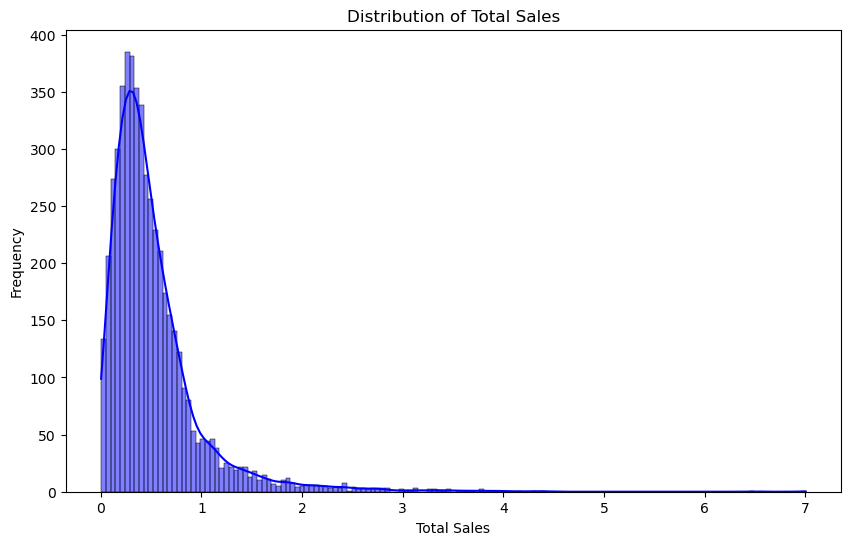

count    5080.000000
mean        0.521160
std         0.481671
min         0.003756
25%         0.239437
50%         0.400000
75%         0.645305
max         7.002817
dtype: float64

In [8]:
# Calculate total sales per item across the 12 numerical values
total_sales = item_sales.sum(axis=1)
total_sales_test = item_sales_test.sum(axis=1)

# Plot the distribution of total sales
plt.figure(figsize=(10, 6))
sns.histplot(total_sales, kde=True, color='blue')
plt.title("Distribution of Total Sales")
plt.xlabel("Total Sales")
plt.ylabel("Frequency")
plt.show()

pd.Series(total_sales).describe()

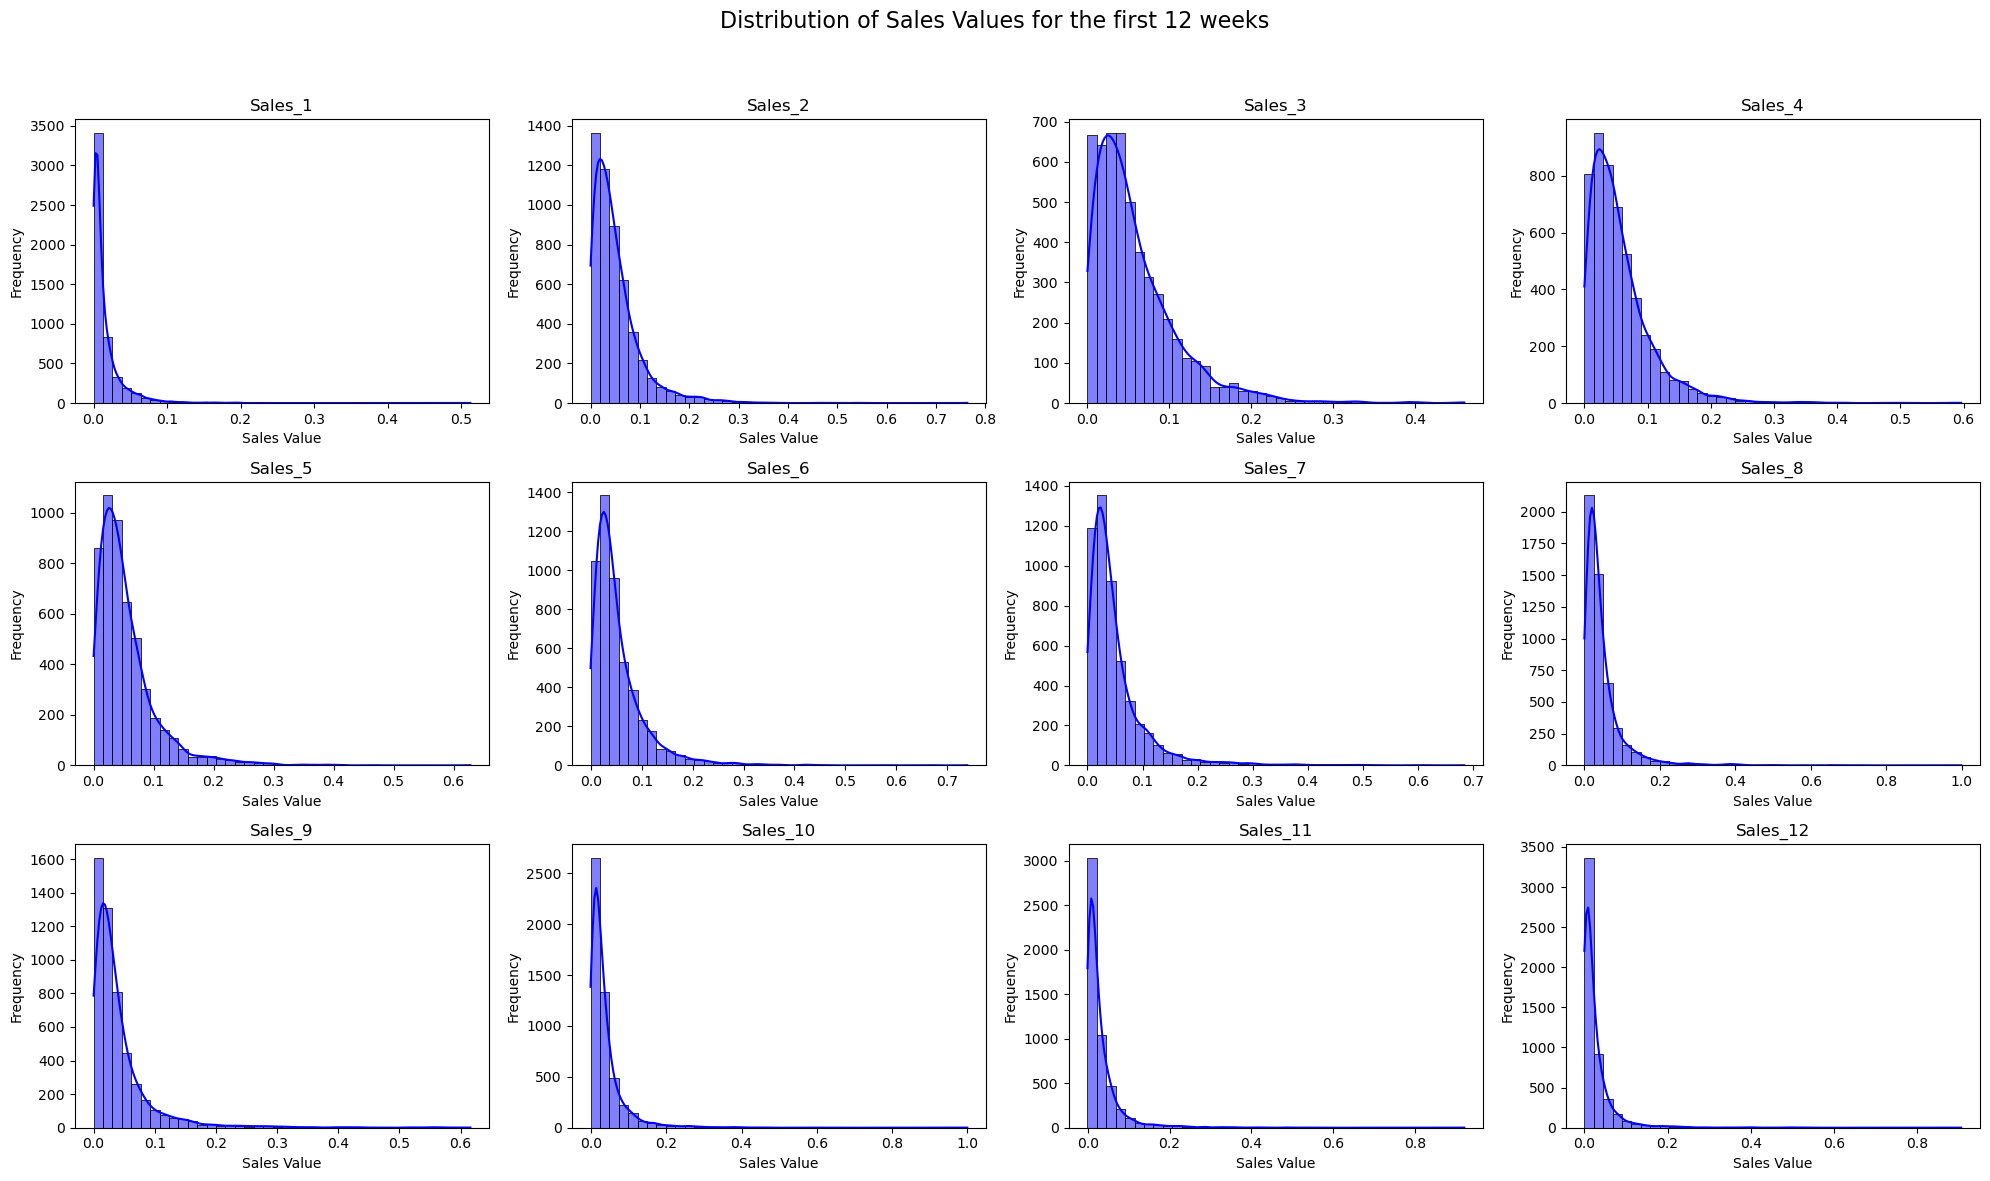

In [11]:
# Set up a grid of 3x4 subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
fig.suptitle("Distribution of Sales Values for the first 12 weeks", fontsize=16)

# Plot each sales distribution in a separate subplot
for i in range(12):
    row = i // 4
    col = i % 4
    sns.histplot(item_sales[:, i], kde=True, color='blue', ax=axes[row, col], bins=40)
    axes[row, col].set_title(f"Sales_{i + 1}")
    axes[row, col].set_xlabel("Sales Value")
    axes[row, col].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

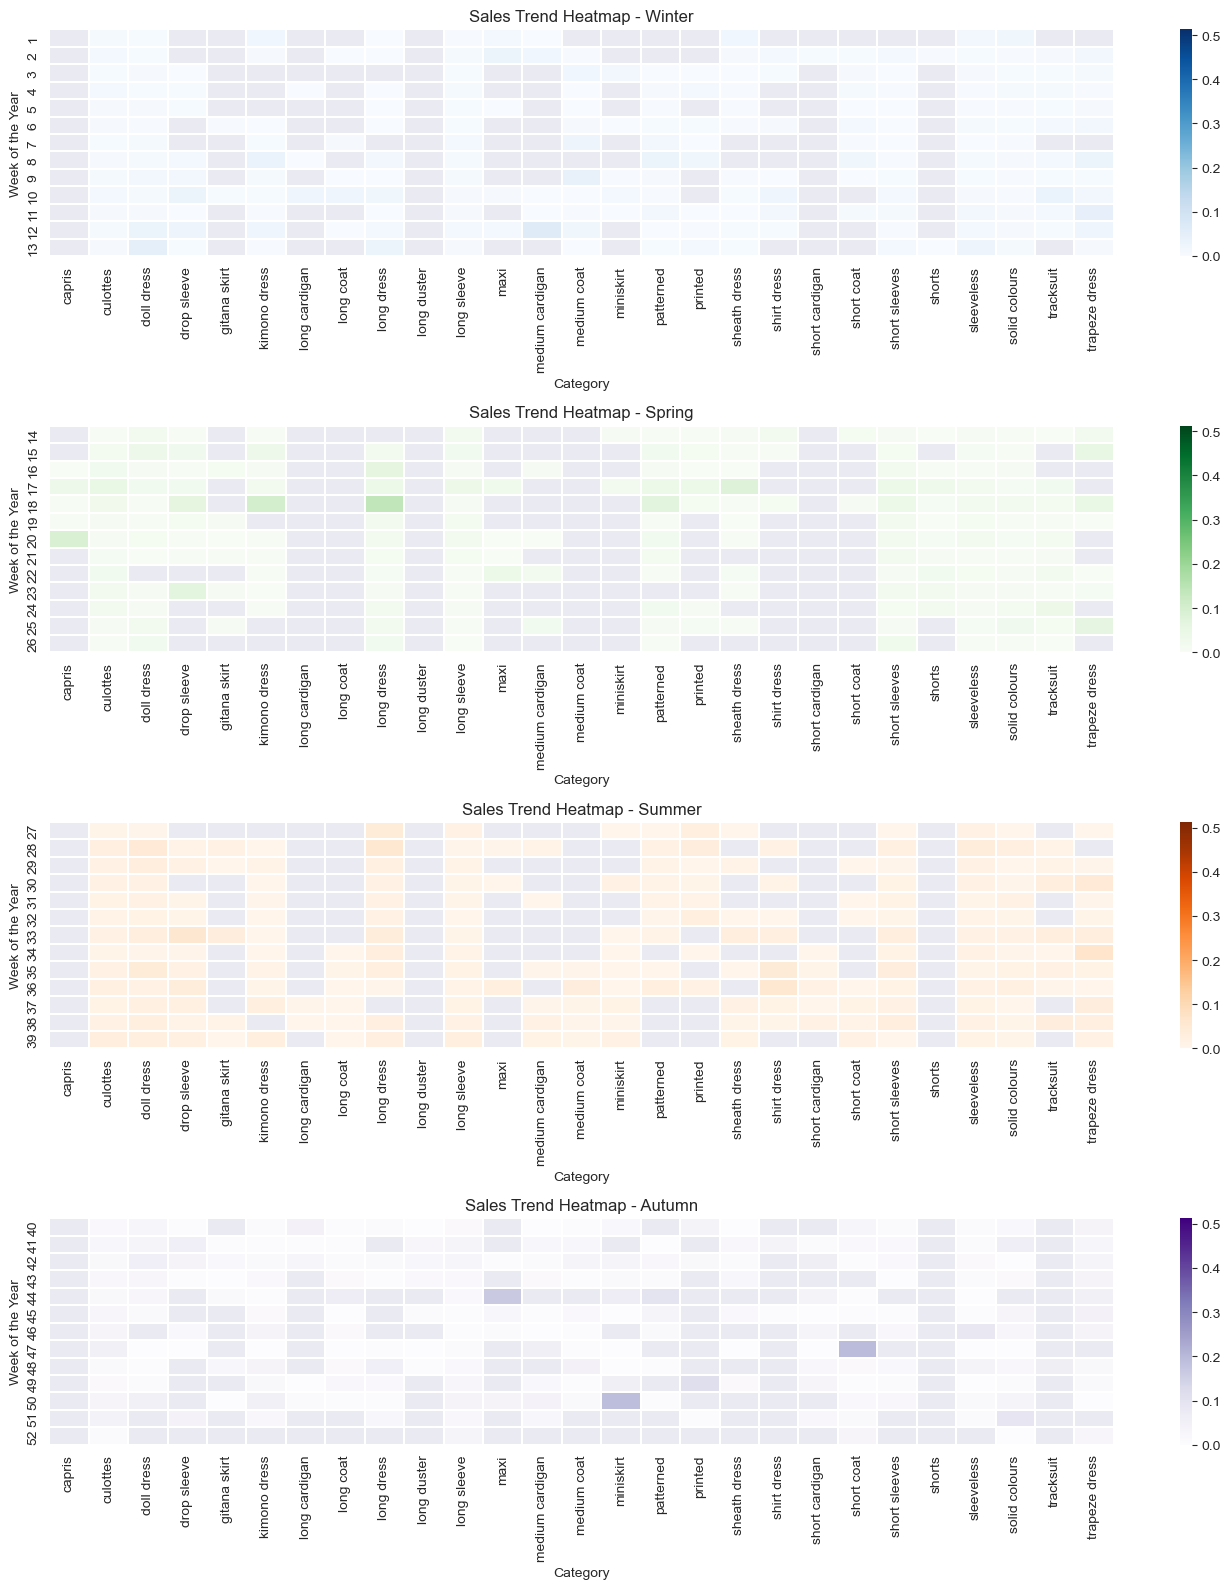

In [28]:
sns.set_style("dark")  # Options: "whitegrid", "darkgrid", "dark", "white", "ticks"

# Convert Week, Month, and Year to proper integers
sales_trend_df = pd.DataFrame({
    "Week": (temporal_features[:, 1] * 52).astype(int),  # Week of the year
    "Month": (temporal_features[:, 2] * 12).astype(int),  # Month of the year
    "Year": (temporal_features[:, 3] * 10).astype(int),  # Year
    # "Total Sales": total_sales,
    "Total Sales": item_sales[:, 0],
    "Category": categories
})



# Define a function to classify weeks into seasons
def classify_season(week):
    if week in range(1, 14):  # Weeks 1-13: Winter
        return "Winter"
    elif week in range(14, 27):  # Weeks 14-26: Spring
        return "Spring"
    elif week in range(27, 40):  # Weeks 27-39: Summer
        return "Summer"
    else:  # Weeks 40-52: Autumn
        return "Autumn"


reversed_cat_dict = {v: k for k, v in cat_dict.items()}

# Apply the classification to create a new Season column
sales_trend_df["Category"] = sales_trend_df["Category"].map(reversed_cat_dict)
all_categories = sorted(sales_trend_df["Category"].unique())

sales_trend_df["Season"] = sales_trend_df["Week"].apply(classify_season)

# Calculate the global min and max for the color scale
global_min = sales_trend_df["Total Sales"].min()
global_max = sales_trend_df["Total Sales"].max()

# Plot the heatmap for each season with different colormaps
plt.figure(figsize=(14, 16))
for i, season in enumerate(["Winter", "Spring", "Summer", "Autumn"]):
    season_data = sales_trend_df[sales_trend_df["Season"] == season]
    season_pivot = season_data.pivot_table(values="Total Sales", index="Week", columns="Category", aggfunc='mean').reindex(columns=all_categories)

    # Plot the heatmap for the current season with a consistent color scale
    plt.subplot(4, 1, i + 1)
    sns.heatmap(season_pivot, cmap="Blues" if season == "Winter" else 
                                      "Greens" if season == "Spring" else 
                                      "Oranges" if season == "Summer" else 
                                      "Purples",
                vmin=global_min, vmax=global_max,
                linewidths=0.1)
    
    plt.title(f"Sales Trend Heatmap - {season}")
    plt.xlabel("Category")
    plt.ylabel("Week of the Year")

plt.tight_layout()
plt.show()

In [77]:
item_sales.shape

(5080, 12)

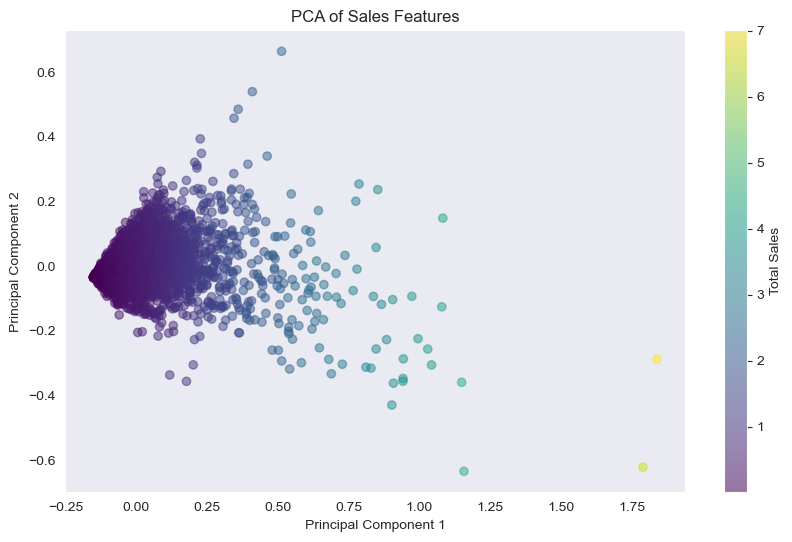

(2, 12)


In [75]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Select features for PCA: let's use the first 12 numerical sales features as an example
features_for_pca = item_sales

# Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_for_pca)

# Create a scatter plot of the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, c=total_sales, cmap='viridis')
plt.colorbar(label="Total Sales")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Sales Features")
plt.show()
print(pca.components_.shape)

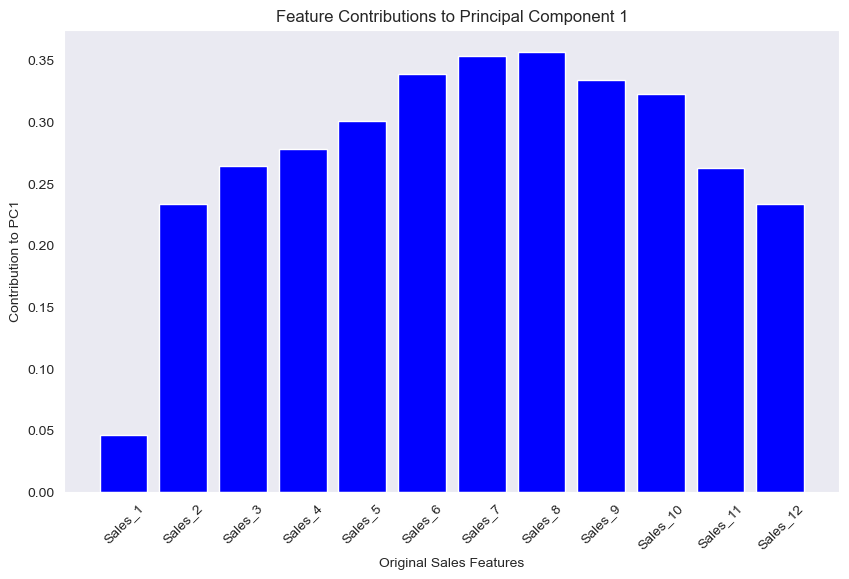

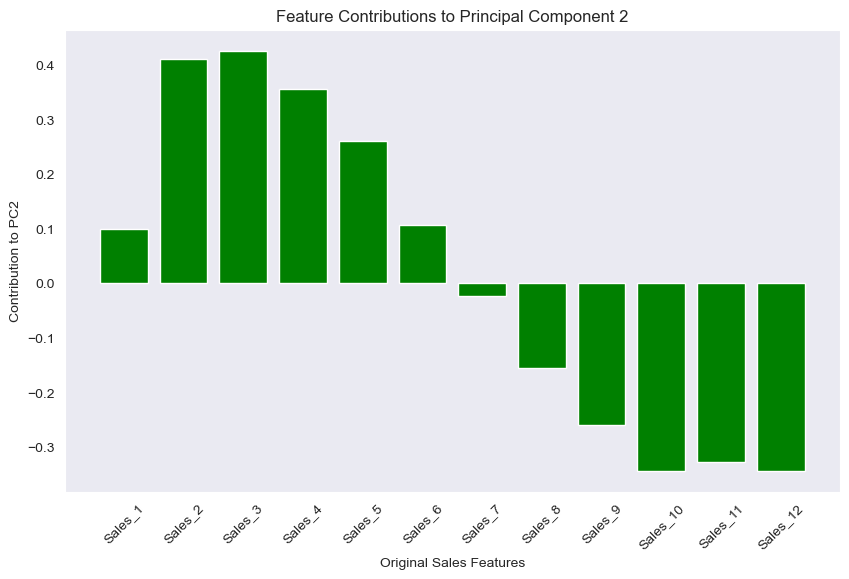

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for easier interpretation
feature_names = [f"Sales_{i+1}" for i in range(12)]
pca_components_df = pd.DataFrame(pca.components_, columns=feature_names, index=["PC1", "PC2"])

# Plot the contributions for PC1
plt.figure(figsize=(10, 6))
plt.bar(feature_names, pca_components_df.loc["PC1"], color='blue')
plt.xlabel("Original Sales Features")
plt.ylabel("Contribution to PC1")
plt.title("Feature Contributions to Principal Component 1")
plt.xticks(rotation=45)
plt.show()

# Plot the contributions for PC2
plt.figure(figsize=(10, 6))
plt.bar(feature_names, pca_components_df.loc["PC2"], color='green')
plt.xlabel("Original Sales Features")
plt.ylabel("Contribution to PC2")
plt.title("Feature Contributions to Principal Component 2")
plt.xticks(rotation=45)
plt.show()

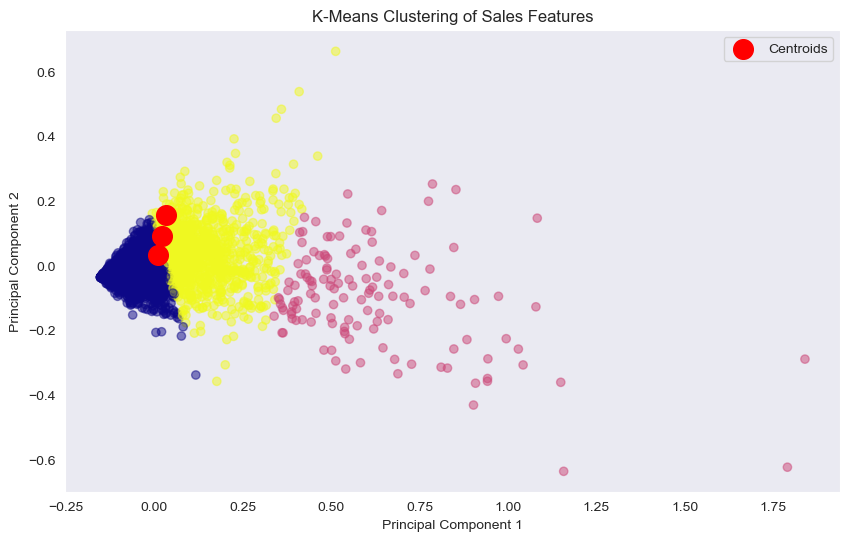

In [73]:
from sklearn.cluster import KMeans

# Apply K-Means clustering (let's use 3 clusters as an example)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features_for_pca)  # Using the same features as in PCA

# Create a scatter plot with clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='plasma', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', label='Centroids')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering of Sales Features")
plt.legend()
plt.show()


### Bag of Words

In [9]:
sift = cv2.SIFT_create()

def extact_sift_features(image_array):
    
    image = np.transpose(image_array, (1, 2, 0))   
    # image = image.astype(np.uint8)
    image = (image / np.max(image) * 255).astype(np.uint8)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return keypoints, descriptors

descriptors_list = []
keypoints_list = []
for image in tqdm(images):
    keypoints, descriptors = extact_sift_features(image)
    
    if descriptors is not None:
        descriptors_list.append(descriptors)
        keypoints_list.append(keypoints)
    else:
        descriptors_list.append(np.zeros((1, 128)))
        keypoints_list.append([])

100%|██████████| 5080/5080 [00:34<00:00, 146.36it/s]


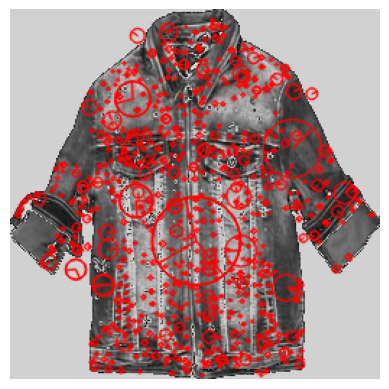

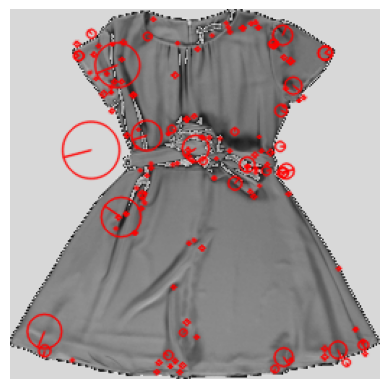

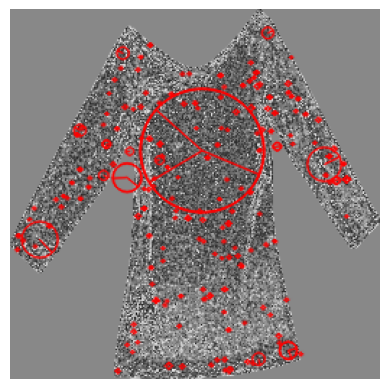

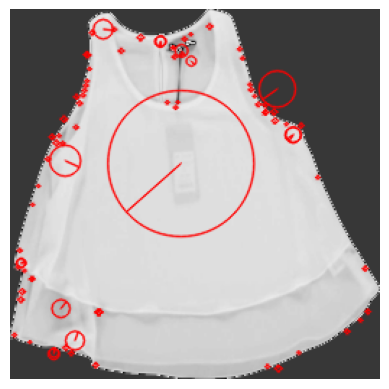

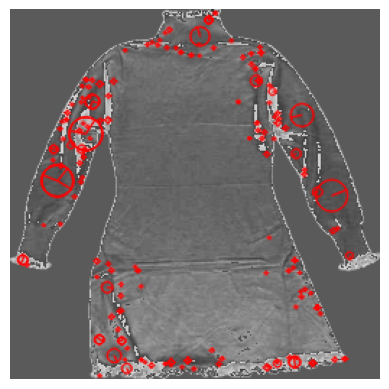

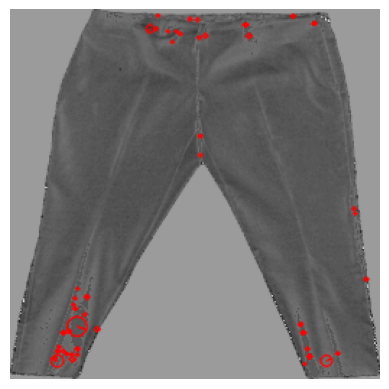

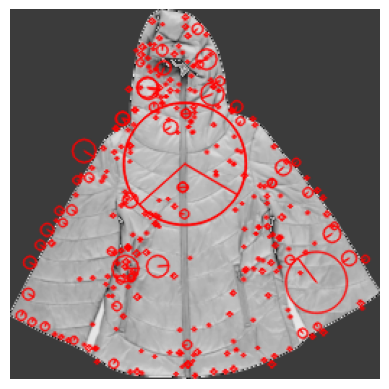

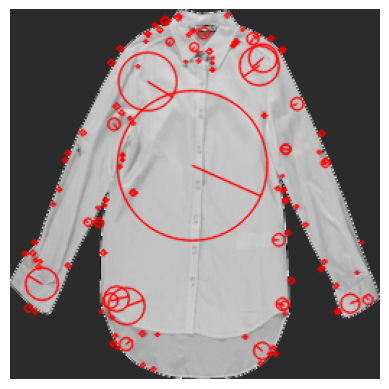

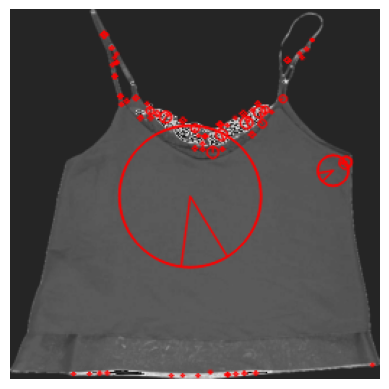

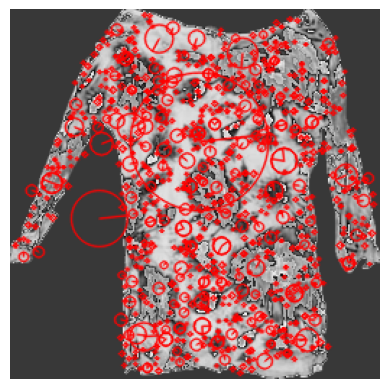

In [10]:
for idx in range(10,20):
    # Load the image from the path
    image = np.transpose(images[idx], (1, 2, 0))   
    # image = image.astype(np.uint8)
    image = (image / np.max(image) * 255).astype(np.uint8)

    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Draw keypoints on the grayscale image
    output_image = cv2.drawKeypoints(
        gray, keypoints_list[idx], None, (255, 0, 0),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    # Display the image with keypoints using Matplotlib
    plt.imshow(output_image, cmap='gray')
    plt.axis('off')  # Hide axes for a cleaner look
    plt.show()

In [11]:
# Stack all descriptors together
all_descriptors = np.vstack(descriptors_list)

# Use K-means to create a visual vocabulary
k = 200  # Number of visual words
kmeans = KMeans(n_clusters=k)
kmeans.fit(all_descriptors)

# Save the cluster centers as the visual vocabulary
visual_words = kmeans.cluster_centers_

In [12]:
# Function to create a histogram of visual words for an image
def create_histogram(descriptors, visual_words):
    histogram = np.zeros(len(visual_words))
    if descriptors is not None:
        words = kmeans.predict(descriptors)
        for word in words:
            histogram[word] += 1
    return histogram

# Create histograms for all images
histograms = []
for idx in tqdm(range(len(images))):
    descriptors = descriptors_list[idx]
    histogram = create_histogram(descriptors, visual_words)
    histograms.append(histogram)

# Convert histograms to a NumPy array
X_train_bovw = np.array(histograms)

histograms_test = []
for idx in tqdm(range(len(images_test))):
    descriptors = extact_sift_features(images_test[idx])[1]
    histogram = create_histogram(descriptors, visual_words)
    histograms_test.append(histogram)

# Convert histograms to a NumPy array
X_test_bovw = np.array(histograms_test)

100%|██████████| 497/497 [00:06<00:00, 78.19it/s]


In [13]:
print(f"Shape of BoVW histograms: {X_train_bovw.shape}")
print(f"Shape of item_sales: {item_sales.shape}")
print(f"Shape of categories: {categories.shape}")
print(f"Shape of colors: {colors.shape}")
print(f"Shape of fabrics: {fabrics.shape}")
print(f"Shape of temporal_features: {temporal_features.shape}")
print(f"Shape of gtrends: {gtrends.shape}")

print(f"Shape test of BoVW histograms: {X_test_bovw.shape}")
print(f"Shape test of item_sales: {item_sales_test.shape}")
print(f"Shape test of categories: {categories_test.shape}")
print(f"Shape test of colors: {colors_test.shape}")
print(f"Shape test of fabrics: {fabrics_test.shape}")
print(f"Shape test of temporal_features: {temporal_features_test.shape}")
print(f"Shape test of gtrends: {gtrends_test.shape}")

Shape of BoVW histograms: (5080, 200)
Shape of item_sales: (5080, 12)
Shape of categories: (5080,)
Shape of colors: (5080,)
Shape of fabrics: (5080,)
Shape of temporal_features: (5080, 4)
Shape of gtrends: (5080, 3, 52)
Shape test of BoVW histograms: (497, 200)
Shape test of item_sales: (497, 12)
Shape test of categories: (497,)
Shape test of colors: (497,)
Shape test of fabrics: (497,)
Shape test of temporal_features: (497, 4)
Shape test of gtrends: (497, 3, 52)


In [15]:
gtrends_flattened = gtrends.reshape(gtrends.shape[0], -1)
gtrends_flattened_test = gtrends_test.reshape(gtrends_test.shape[0], -1)
# Possible to compute statistical figures

In [49]:
gtrends_flattened.shape

(5080, 156)

In [16]:
X_train = np.hstack((
    X_train_bovw,           
    temporal_features,        
    gtrends_flattened,
    categories.reshape(-1, 1),
    colors.reshape(-1, 1),
    fabrics.reshape(-1, 1)
))

X_test = np.hstack((
    X_test_bovw,
    temporal_features_test,
    gtrends_flattened_test,
    categories_test.reshape(-1, 1),
    colors_test.reshape(-1, 1),
    fabrics_test.reshape(-1, 1)
))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = total_sales
y_test = total_sales_test

y_train = item_sales[:, 0]
y_test = item_sales_test[:, 0]

In [17]:
# Initialize the XGBoost regressor
model = XGBRegressor(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Learning rate
    max_depth=6,        # Maximum depth of a tree
    random_state=42,
    n_jobs=-1           # Use all CPU cores
)

# Train the model
print("Training the regression model...")
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

Training the regression model...


In [18]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error on Test Set: {mse}")
print(f"Mean Absolute Error on Test Set: {mae}")

Mean Squared Error on Test Set: 0.0008077869424596429
Mean Absolute Error on Test Set: 0.019546551629900932


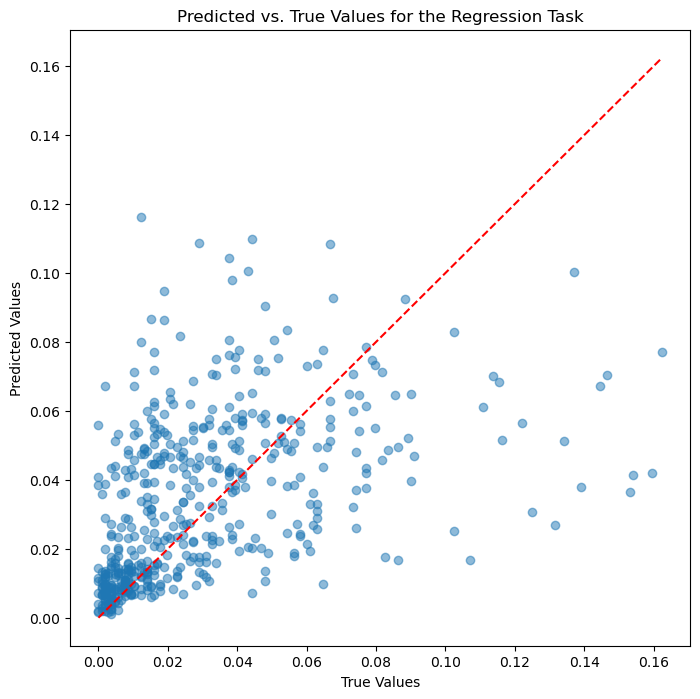

In [19]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values for the Regression Task")
plt.plot([min(y_test), max(y_test)],
         [min(y_test), max(y_test)], 'r--')
plt.show()

In [20]:

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 8]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=0,
    n_jobs=-1
)

# Perform grid search
print("Performing grid search...")
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

Performing grid search...
Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Best Score: 0.0003367047989740968


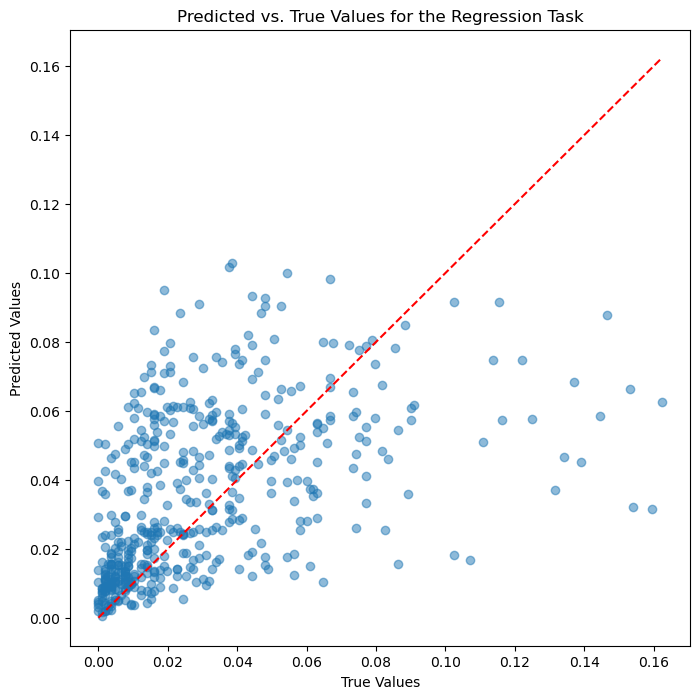

Mean Squared Error on Test Set: 0.0007980830268934369
Mean Absolute Error on Test Set: 0.020053241401910782


In [21]:
# Get the best model from the Grid Search
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred_bm = best_model.predict(X_test)

# Plot the Predicted vs. True Values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_bm, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values for the Regression Task")
plt.plot([min(y_test), max(y_test)],
         [min(y_test), max(y_test)], 'r--')  # Line y = x for reference
plt.show()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_bm)
mae = mean_absolute_error(y_test, y_pred_bm)

print(f"Mean Squared Error on Test Set: {mse}")
print(f"Mean Absolute Error on Test Set: {mae}")

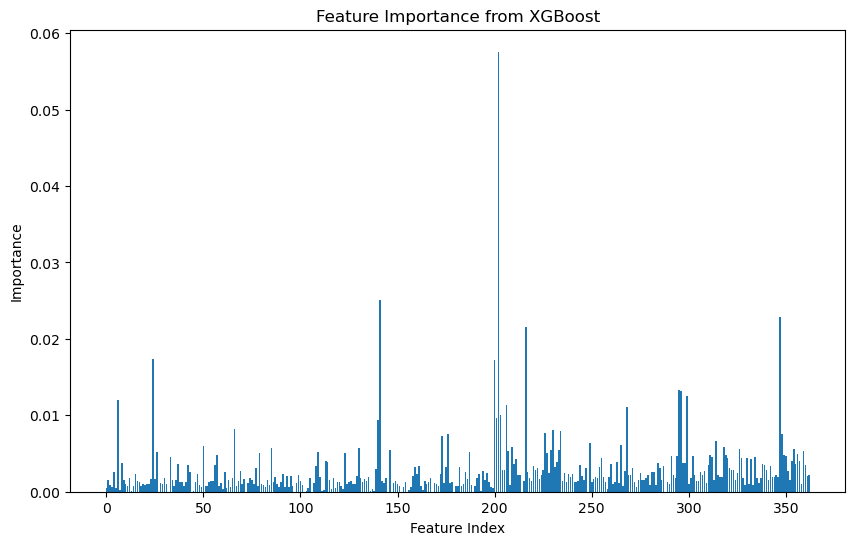

In [22]:
importance = best_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), importance)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance from XGBoost")
plt.show()

In [23]:
# Set a threshold for feature importance
threshold = 0.01  # Adjust based on how many features you want to keep
important_features_indices = np.where(importance > threshold)[0]

# Select the important features
X_train_important = X_train[:, important_features_indices]
X_test_important = X_test[:, important_features_indices]
print(f"Shape of reduced features: {X_train_important.shape}")

Shape of reduced features: (5080, 13)


In [24]:
# Train the model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train_important, y_train)

# Make predictions and evaluate
y_pred_imp = model.predict(X_test_important)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error with Important Features: {mse}")

Mean Squared Error with Important Features: 0.0008077869424596429


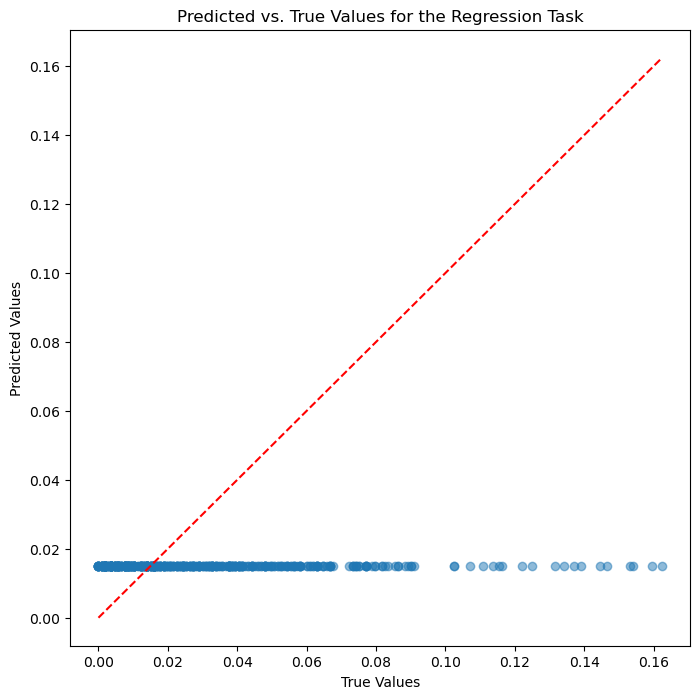

Mean Squared Error on Test Set: 0.00112123571047348
Mean Absolute Error on Test Set: 0.021581880405351896


In [25]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply Lasso regression
lasso = Lasso(alpha=0.015)  # Adjust alpha for the strength of regularization
lasso.fit(X_train_scaled, y_train)

y_pred_lasso = lasso.predict(scaler.transform(X_test))

# Get the coefficients
lasso_coefficients = lasso.coef_

# Plot the Predicted vs. True Values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values for the Regression Task")
plt.plot([min(y_test), max(y_test)],
         [min(y_test), max(y_test)], 'r--')  # Line y = x for reference
plt.show()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_lasso)
mae = mean_absolute_error(y_test, y_pred_lasso)

print(f"Mean Squared Error on Test Set: {mse}")
print(f"Mean Absolute Error on Test Set: {mae}")

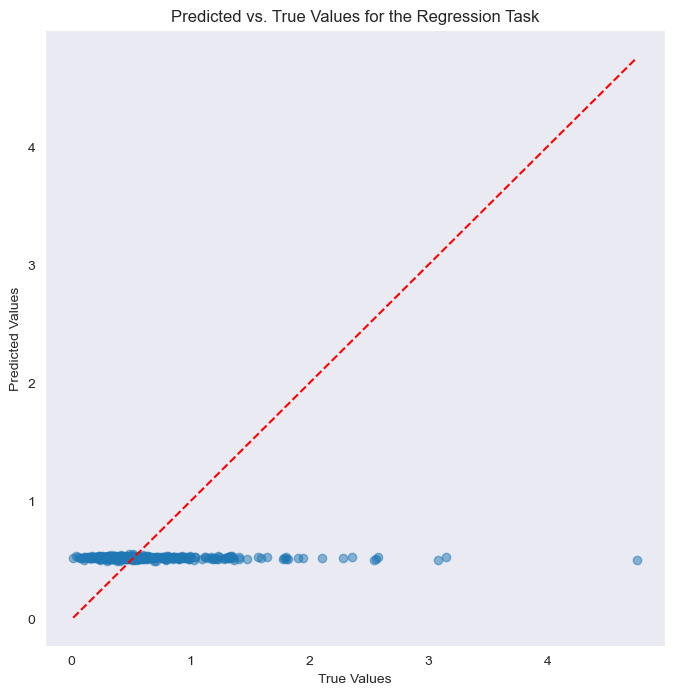

Mean Squared Error on Test Set: 0.2079427101892498
Mean Absolute Error on Test Set: 0.2530742177585954


In [114]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bovw)

# Apply Lasso regression
lasso = Lasso(alpha=0.01)  # Adjust alpha for the strength of regularization
lasso.fit(X_train_scaled, y_train)

y_pred_lasso = lasso.predict(scaler.transform(X_test_bovw))

# Get the coefficients
lasso_coefficients = lasso.coef_

# Plot the Predicted vs. True Values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values for the Regression Task")
plt.plot([min(y_test), max(y_test)],
         [min(y_test), max(y_test)], 'r--')  # Line y = x for reference
plt.show()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_lasso)
mae = mean_absolute_error(y_test, y_pred_lasso)

print(f"Mean Squared Error on Test Set: {mse}")
print(f"Mean Absolute Error on Test Set: {mae}")

In [26]:
# Transform the target variable using log1p
y_train_transformed = np.log1p(y_train)
y_test_transformed = np.log1p(y_test)

# y_train_transformed = np.sqrt(y_train)
# y_test_transformed = np.sqrt(y_test)


# Train the model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train_transformed)

# Make predictions and transform them back to the original scale
y_pred_transformed = model.predict(X_test)

y_pred = np.expm1(y_pred_transformed)  # Inverse of log1p

# Evaluate the model
mse = mean_squared_error(y_test_transformed, y_pred_transformed)  # Use the transformed target
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.0006782413693144917


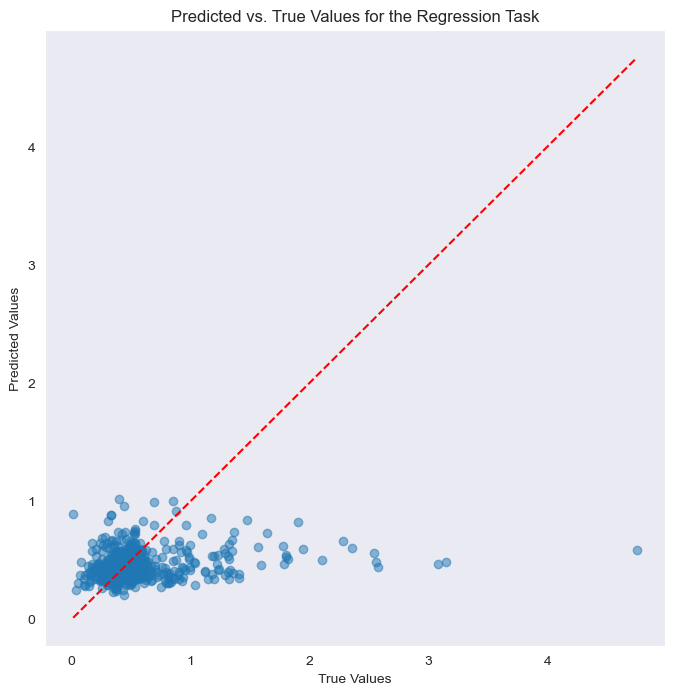

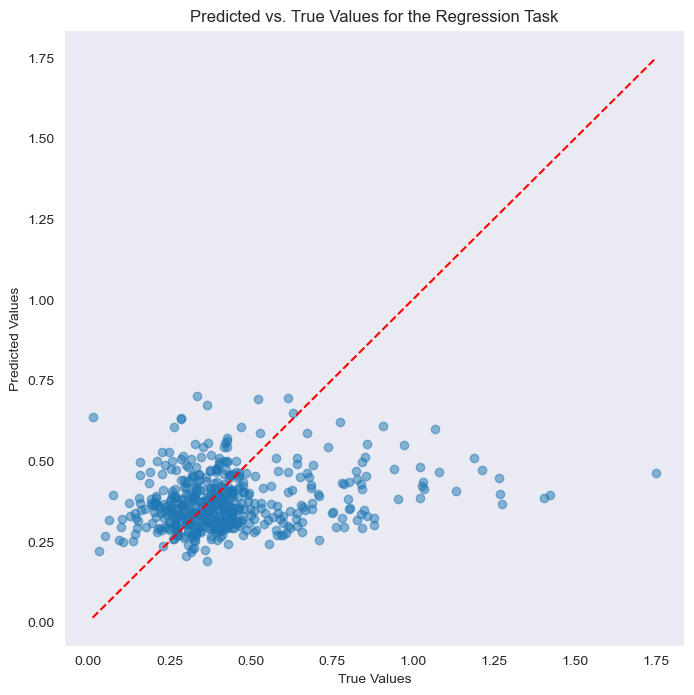

Mean Squared Error on Test Set: 0.21266327798366547
Mean Absolute Error on Test Set: 0.25937238335609436


In [121]:
# Plot the Predicted vs. True Values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values for the Regression Task")
plt.plot([min(y_test), max(y_test)],
         [min(y_test), max(y_test)], 'r--')  # Line y = x for reference
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(y_test_transformed, y_pred_transformed, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values for the Regression Task")
plt.plot([min(y_test_transformed), max(y_test_transformed)],
         [min(y_test_transformed), max(y_test_transformed)], 'r--')  # Line y = x for reference
plt.show()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print(f"Mean Squared Error on Test Set: {mse}")
print(f"Mean Absolute Error on Test Set: {mae}")

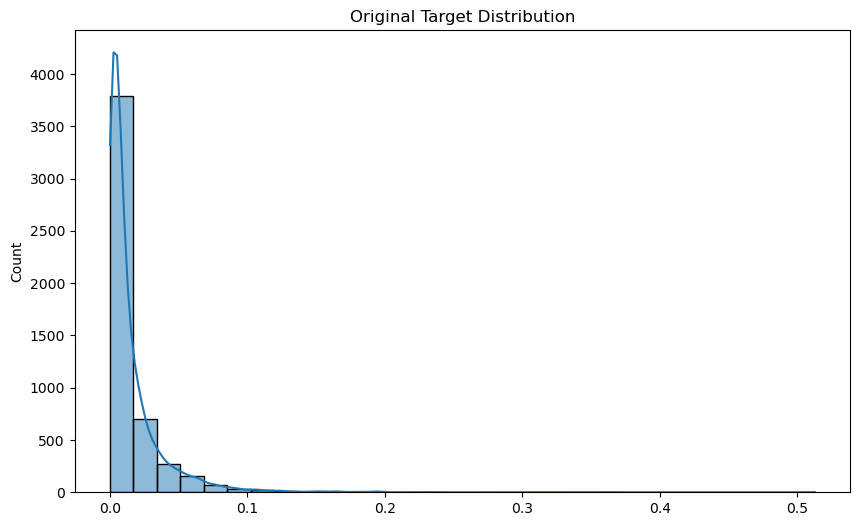

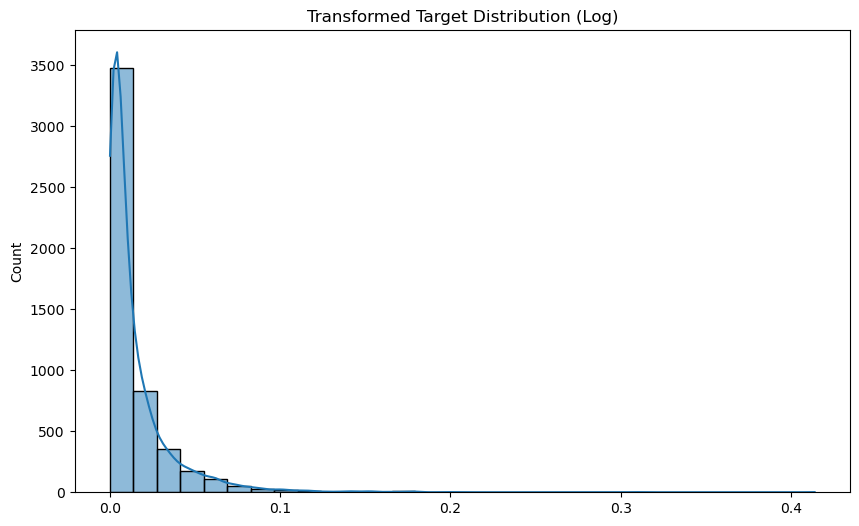

In [27]:
# Original target distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=30, kde=True)
plt.title('Original Target Distribution')
plt.show()

# Transformed target distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_train_transformed, bins=30, kde=True)
plt.title('Transformed Target Distribution (Log)')
plt.show()


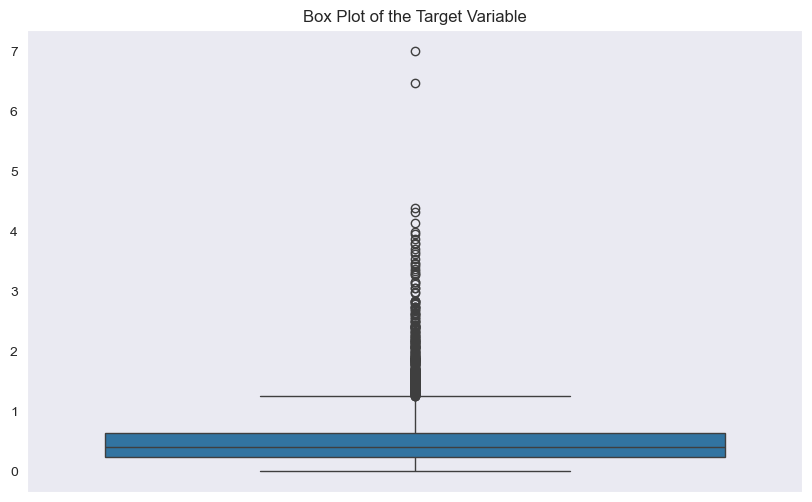

In [123]:
# Check for outliers in the target variable
plt.figure(figsize=(10, 6))
sns.boxplot(sale)
plt.title('Box Plot of the Target Variable')
plt.show()
